In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imutils
from imutils import paths
from imutils.video import VideoStream
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import cv2

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [26]:
print("[INFO] loading images...")
DATA_PATH = "dataset"
imagePaths = list(paths.list_images(DATA_PATH))
data = []
labels = []

for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


[INFO] loading images...


c:\users\kabilan n\appdata\local\programs\python\python39\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
data

array([[[[-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         ...,
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.84313726, -0.8980392 , -0.77254903]],

        [[-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         ...,
         [-0.7490196 , -0.8039216 , -0.6784314 ],
         [-0.7490196 , -0.8039216 , -0.6784314 ],
         [-0.7411765 , -0.79607844, -0.67058825]],

        [[-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9529412 , -0.81960785],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         ...,
         [-0.88235295, -0.8980392 , -0.7882353 ],
         [-0.85882354, -0.8901961 , -0.77254903],
         [-0.85882354, -0.8745098 , -0.7647059 ]],

        ...,

        [[ 0.38823533, -0.9607843 , -0

In [28]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [29]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [30]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [31]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


In [32]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [33]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [34]:
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


C:\Users\kabilan N\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
102/102 [==============================] - 417s 4s/step - loss: 0.4388 - accuracy: 0.8328 - val_loss: 0.1828 - val_accuracy: 0.9744
Epoch 2/20
102/102 [==============================] - 178s 2s/step - loss: 0.1587 - accuracy: 0.9614 - val_loss: 0.1000 - val_accuracy: 0.9817
Epoch 3/20
102/102 [==============================] - 180s 2s/step - loss: 0.1113 - accuracy: 0.9695 - val_loss: 0.0775 - val_accuracy: 0.9829
Epoch 4/20
102/102 [==============================] - 178s 2s/step - loss: 0.0811 - accuracy: 0.9769 - val_loss: 0.0642 - val_accuracy: 0.9841
Epoch 5/20
102/102 [==============================] - 173s 2s/step - loss: 0.0747 - accuracy: 0.9793 - val_loss: 0.0578 - val_accuracy: 0.9853
Epoch 6/20
102/102 [==============================] - 173s 2s/step - loss: 0.0626 - accuracy: 0.9812 - val_loss: 0.0623 - val_accuracy: 0.9841
Epoch 7/20
102/102 [==============================] - 179s 2s/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.054

In [36]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [37]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       433
without_mask       0.98      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819



In [44]:
print("[INFO] saving mask detector model...")
model.save("model", save_format="h5")

[INFO] saving mask detector model...


In [42]:
import tensorflow as tf
tf.keras.models.save_model(model,'mask_det.hdf5')

C:\Users\kabilan N\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


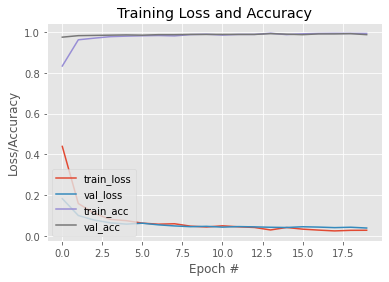

In [46]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")